# Loan Prediction

This is a project where we will try to predict if a loan application will be approved or not. In general, this is a **classification** problem where we try to predict if an application (row in data) will be approved (1) or not approved (0). 

We will tackle this problem by trying different types of classification models. 

Of course, before starting to build models first we will explore the data and try to understand the basic statistics which will give us an idea on how to proceed. 
Another important part before the model building is to actually clean, prepare and transform the data so that it will be useful and better for classification

## Import Libraries

In [1543]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os

os.chdir('C:\\Users\\user11\\Desktop\\DS Projects')

In [1544]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [1545]:
df = pd.read_csv('Loan Prediction\\trainset.csv')

We will basically use the train set (df) to understand the data, clean and visualize the data and of course build and tune the model. We will fit our models using this data.

In [1546]:
#Show the top 5 of the dataset
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data Exploration

Let's start to get the basic statistics of the data.

In [1547]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [1548]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


We can see that there are missing values in some of the features. Before we go on to taking care of the missing values, first we will get some insights about the data by visualizations.

<Figure size 1080x360 with 0 Axes>

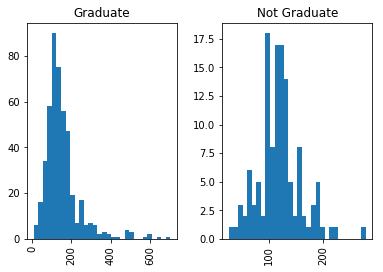

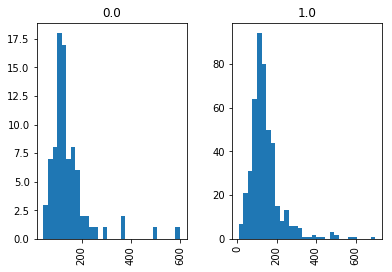

In [1549]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot()
df.hist('LoanAmount', by='Education', bins=30, grid=False, ax=ax1)
plt.show()

ax2 = fig.add_subplot()
df.hist('LoanAmount', by='Credit_History', bins=30, grid=False, ax=ax2)
plt.show()

Now let's comapre the applications from different areas (Urban, Semiurban, Rural) to dwelve deeper into the data.

In [1550]:
df.groupby('Property_Area').agg({'Loan_ID': 'count', 'LoanAmount': 'mean'}) \
  .rename(columns={'Loan_ID': 'Num_Loans', 'LoanAmount' : 'Avg_Loan'})

,Num_Loans,Avg_Loan
Property_Area,,
Rural,179,152.260116
Semiurban,233,145.504386
Urban,202,142.198953


Other ways of doing the same thing and getting the same values. (Just to show)

In [1551]:
#Method 1 - Pivot Table
df.pivot_table(values='LoanAmount', index='Property_Area')

,LoanAmount
Property_Area,
Rural,152.260116
Semiurban,145.504386
Urban,142.198953


In [1552]:
#Method 2 - Count, Mean etc. by column
df['Property_Area'].value_counts()

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64

How about Credit History?

In [1553]:
df.groupby('Credit_History').agg({'Loan_ID': 'count', 'LoanAmount': 'mean'}) \
  .rename(columns={'Loan_ID': 'Num_Loans', 'LoanAmount' : 'Avg_Loan'})

,Num_Loans,Avg_Loan
Credit_History,,
0.0,89,146.717647
1.0,475,144.786026


Now let's see how our target variable (Loan_Status) is distributed.

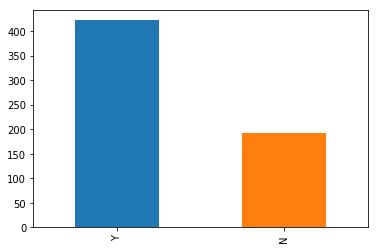

In [1554]:
statuscount = df['Loan_Status'].value_counts()
statuscount.plot(kind='bar');

It can be seen that we have a lot more approved loans than not approved ones. We will use the data as is now but for further improvements we can use SMOTE to sample more unapproved loan data.

## Data Wrangling

### Handling Missing Values

After getting some insight on the data, now we can start using this information to take care of the missing values

In [1555]:
#Number of missing values in each feature
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

First of all let's check if there are any rows that not really informative. That means, we'll check if there are rows with more than a threshold of missing values.

In [1556]:
threshold = 2
df[df.isnull().sum(1) > threshold]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


Only 8 rows with more than 2 missing values and none with more than 3. No need to leave out these rows as they can still be informative after taking care of the missing values.

Each feature should be taken into consideration separately in order to impute missing values. This is even more important taken into account there are both numerical and categorical features.

#### Categorical Features

In [1557]:
df['Gender'].value_counts()

Male      489
Female    112
Name: Gender, dtype: int64

In [1558]:
df['Married'].value_counts()

Yes    398
No     213
Name: Married, dtype: int64

In [1559]:
df['Dependents'].value_counts()

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64

In [1560]:
df['Self_Employed'].value_counts()

No     500
Yes     82
Name: Self_Employed, dtype: int64

In [1561]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

We see a significant portion of the loans are by married, male and not self-employed clients with 0 dependents and a credit history. We will assume the missing values would also be according to this pattern for the sake of simplicity.

In [1562]:
df['Gender'].fillna('Male', inplace=True)
df['Married'].fillna('Yes', inplace=True)
df['Dependents'].fillna(0, inplace=True)
df['Self_Employed'].fillna('No', inplace=True)
df['Credit_History'].fillna(1, inplace=True)

#### Continuous Features

For the continuous features we will use the average value for each of them. Keep in mind there are many more sophisticated methods to impute missing values but again, we will keep it simple for now.

In [1563]:
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mean(), inplace=True)

Now, let's check again that we don't have missing values in any of the columns anymore

In [1564]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Feature Engineering

#### New Features

Let's create a new feature called 'Total Income' which includes both applicant income and coapplicant income as loan approval probably depends on the total income rather than the incomes or individuals applying.

In [1565]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

Second, let's create a more informative feature called 'Monthly Loan' which might give us an idea if the loan is "safe" depending on the loan amount and total income of the applicants.

In [1566]:
df['MonthlyLoan'] = (df['LoanAmount']*1000) / df['Loan_Amount_Term']

In [1567]:
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,MonthlyLoan
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,5849.0,406.700450
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,6091.0,355.555556
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,3000.0,183.333333
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,4941.0,333.333333
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,6000.0,391.666667


#### Scaling

We know that Loan Amount is actually in thousands. We need to scale loan amount and total income features in order to get a better model.

In [1568]:
from sklearn import preprocessing
scaler=preprocessing.StandardScaler(with_mean=False)
cols_to_scale = ['TotalIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'MonthlyLoan']
df[cols_to_scale]=scaler.fit_transform(df[cols_to_scale])

In [1569]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,MonthlyLoan
0,LP001002,Male,No,0,Graduate,No,5849,0.0,1.743645,5.597011,2.840493,Urban,Y,0.906344,0.796594
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,1.524372,5.597011,2.840493,Rural,N,0.943843,0.696418
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,0.786004,5.597011,2.840493,Urban,Y,0.464871,0.359091
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,1.429099,5.597011,2.840493,Urban,Y,0.765643,0.652892
4,LP001008,Male,No,0,Graduate,No,6000,0.0,1.679191,5.597011,2.840493,Urban,Y,0.929742,0.767148


### Handling Outliers and Extreme Values

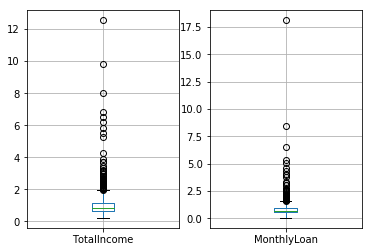

In [1570]:
plt.subplot(121)
df.boxplot('TotalIncome')

plt.subplot(122)
df.boxplot('MonthlyLoan')

We saw before in the histograms that there are some extreme values in the data. It would be hard to call them outliers as it's not really 'illogical' and these values for income or loan amount etc. can actually be present. However, of course, we don't want them to affect the prediction as much as the rest. 

We will use log transformation to take care of the extreme values in Total Income and Loan Amount columns. 

In [1571]:
df['MonthlyLoan_log'] = df['MonthlyLoan'].apply(np.log)
df['TotalIncome_log'] = df['TotalIncome'].apply(np.log)

Let's see the difference now!

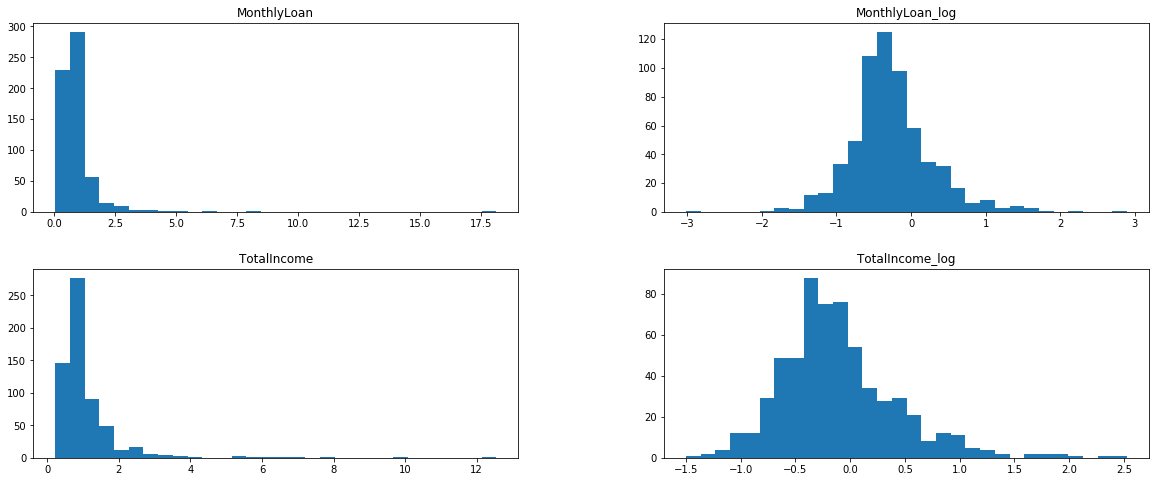

In [1572]:
fig = plt.figure(figsize=(20, 8));

ax1 = fig.add_subplot(221)
df.hist('MonthlyLoan', bins=30, grid=False, ax=ax1);
ax2 = fig.add_subplot(222)
df.hist('MonthlyLoan_log', bins=30, grid=False, ax=ax2);
ax3 = fig.add_subplot(223)
df.hist('TotalIncome', bins=30, grid=False, ax=ax3);
ax4 = fig.add_subplot(224)
df.hist('TotalIncome_log', bins=30, grid=False, ax=ax4);

## Data Preparation

In [1573]:
from sklearn.preprocessing import LabelEncoder
cols_to_encode = ['Gender','Married','Education','Self_Employed','Property_Area','Loan_Status', 'Dependents']
le = LabelEncoder()
for col in cols_to_encode:
    df[col] = le.fit_transform(df[col].astype(str))

In [1574]:
df.head(10)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,MonthlyLoan,MonthlyLoan_log,TotalIncome_log
0,LP001002,1,0,0,0,0,5849,0.0,1.743645,5.597011,2.840493,2,1,0.906344,0.796594,-0.227410,-0.098337
1,LP001003,1,1,1,0,0,4583,1508.0,1.524372,5.597011,2.840493,0,0,0.943843,0.696418,-0.361805,-0.057795
2,LP001005,1,1,0,0,1,3000,0.0,0.786004,5.597011,2.840493,2,1,0.464871,0.359091,-1.024180,-0.765995
3,LP001006,1,1,0,1,0,2583,2358.0,1.429099,5.597011,2.840493,2,1,0.765643,0.652892,-0.426343,-0.267040
4,LP001008,1,0,0,0,0,6000,0.0,1.679191,5.597011,2.840493,2,1,0.929742,0.767148,-0.265075,-0.072848
5,LP001011,1,1,2,0,1,5417,4196.0,3.179745,5.597011,2.840493,2,1,1.489602,1.452685,0.373413,0.398509
6,LP001013,1,1,0,1,0,2333,1516.0,1.131370,5.597011,2.840493,2,1,0.596430,0.516873,-0.659958,-0.516794
7,LP001014,1,1,3,0,0,3036,2504.0,1.881647,5.597011,0.000000,1,0,0.858462,0.859641,-0.151240,-0.152613
8,LP001018,1,1,2,0,0,4006,1526.0,2.000738,5.597011,2.840493,2,1,0.857222,0.914049,-0.089871,-0.154058
9,LP001020,1,1,1,0,0,12841,10968.0,4.156296,5.597011,2.840493,1,0,3.689372,1.898828,0.641237,1.305456


In [1575]:
cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', \
        'Credit_History', 'Property_Area', 'TotalIncome_log', 'MonthlyLoan_log']
X = df[cols]
Y = df['Loan_Status']

## Classification Models

In order to be able to decide if a loan would be approved or not we will build a classification model on our train data. We will use more than just one model and evaluate each of them to choose the best one for the test set at the end.

### Logistic Regresion

We will fit a Logistic Regression classifier using all the features.

In [1582]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(C=0.1)
model1.fit(X, Y)

#make predictions
actual = Y
predicted = model1.predict(X)

#Accuracy
metrics.accuracy_score(actual,predicted)

c:\users\user11\anaconda3\envs\tensorflow_env2\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8094462540716613

### Decision Tree

In [1579]:
from sklearn.tree import DecisionTreeClassifier
model2 = DecisionTreeClassifier()
model2.fit(X, Y)

#make predictions
actual2 = Y
predicted2 = model2.predict(X)

#Accuracy score
metrics.accuracy_score(actual2,predicted2)

1.0

We getting 100% accuracy because we are using the exact training data here for evaluation (Test data is a separate file). At the time of training, decision tree gained the knowledge about the data, and now when we give same data to predict it will give exactly same value. That's why decision tree producing correct results every time.

### Random Forest

In [1580]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier()
model3.fit(X, Y)

#make predictions
actual3 = Y
predicted3 = model3.predict(X)

#Accuracy score
metrics.accuracy_score(actual3,predicted3)

c:\users\user11\anaconda3\envs\tensorflow_env2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9837133550488599

### KNN

In [1581]:
from sklearn.neighbors import KNeighborsClassifier
model4 = KNeighborsClassifier(n_neighbors=5)
model4.fit(X, Y)

#make predictions
actual4 = Y
predicted4 = model4.predict(X)

#Accuracy score
metrics.accuracy_score(actual4,predicted4)

0.8257328990228013

## Model Comparison

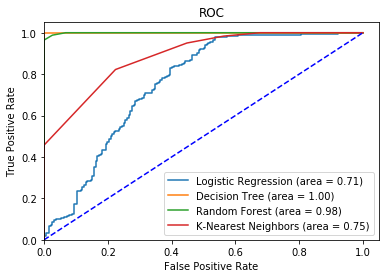

In [1587]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

model1_auc = roc_auc_score(actual, predicted)
fpr, tpr, thresholds = roc_curve(actual, model1.predict_proba(X)[:,1])

model2_auc = roc_auc_score(actual, predicted2)
fpr2, tpr2, thresholds2 = roc_curve(actual, model2.predict_proba(X)[:,1])

model3_auc = roc_auc_score(actual, predicted3)
fpr3, tpr3, thresholds3 = roc_curve(actual, model3.predict_proba(X)[:,1])

model4_auc = roc_auc_score(actual, predicted4)
fpr4, tpr4, thresholds4 = roc_curve(actual, model4.predict_proba(X)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % model1_auc)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % model2_auc)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % model3_auc)
plt.plot(fpr4, tpr4, label='K-Nearest Neighbors (area = %0.2f)' % model4_auc)

plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()